## Site Visit Route Optimizer (SiViRO)
## Solution #2: Google Maps Directions Route Optimizer

### DSI-8    August 2019

### Team: Sade Ekulona, Nick Minaie, Jeremy Opacich, Andrew Picart 

In this notebook, we will utilize Google Map's directions to optimize the route between the origin, the destination, and the intermediate stops (or waypoints, the properties to be visited).

Documentation for the Google Maps API can be found here ([Google Maps Directions](https://developers.google.com/maps/documentation/directions/start)).

The documentation explains that the directions feature can also optimize the waypoints, which are the property stops.



`gmaps.directions(origin,
                 destination, 
                 mode='driving',
                waypoints,
                optimize_waypoints=True)`

In this case, waypoints will be a list of intermediate stops. If `optimize_waypoints` is set to `True`, then Google Maps will re-order waypoints to optimize the route based on driving duration (or time). The optimizer uses **Traveling Salesman Problem** to arrive at the most optimum solution. 

The API returns a JSON response, that includes the order of the waypoints in the optimized solution. 


**NOTE:** In our other notebook (***SiViRO_Site_Visit_Route_Optimizer_TSP.ipynb***), we go over our own algorithm, which is based on the concept of **TSP** and **Genetic Algorithm** as well as **Unsupervised Learning** (Clustering) to arrive at an optimized solution for this problem.

In [1]:
#Imports
import googlemaps
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import gmaps as gm

In [2]:
# Reading API key
with open('/Users/nick/dsi/google_api.txt') as f:
    api_key = f.readline()[:-1]
    f.close

In [3]:
# Instantiate a gmaps engine
gmaps = googlemaps.Client(key=api_key)

In [4]:
# Getting the Origin
origin = input('Please enter origin\'s address: ')

Please enter origin's address: 1938 4th St NW, Washington DC


In [5]:
# These are random addresses. These will be obtained from the list of applications
# Or from the prioritized list of applications

addresses = [
    origin,       # Adding origin at the beginning
    '822 Mason Ave, Deale, MD',
    '6347 Genoa Rd, Tracys Landing, MD',
    '719 Walnut Ave, North Beach, MD',
    '8326 Bayside Rd, Chesapeake Beach, MD',
    '8630 Fort Foote Rd, Fort Washington, MD',
    '11400 Riverview Rd, Fort Washington, MD',
    '3808 Dunlap St, Temple Hills, MD',
    '1202 I St, Alexandria, VA 22307',
    '4908 King Patrick Way, Upper Marlboro, MD',
    '4002 Fox Gate Ln, Upper Marlboro, MD',
    '5819 Whipoorwill Dr, Deale, MD'
]

In [6]:
# Making it a round trip?
round_trip=''
while round_trip not in ['y','n']:
    round_trip = input('Do you want to come back to the orign (round trip)? (y/n) ')

Do you want to come back to the orign (round trip)? (y/n) n


In [7]:
# If round_trip='y' then add origin at the end of addresses
# otherwise, pass, which means the last stop will be the last address
if round_trip == 'y':
    addresses.append(origin)
else:
    destination = input('Enter the final destination\'s address: ')
    addresses.append(destination)

Do you want the final destination to be the last property? (y/n)n
Enter the final destination's address: 8421 Broad St, McLean, VA


In [8]:
# A fuction that returns the lat and long of an address (geocodes)
def address_geocode(address):
    
    # Geocoding an address
    geocode = gmaps.geocode(address)
    
    # Get latitude
    lat = geocode[0]['geometry']['location']['lat']

    # Get longitude
    long = geocode[0]['geometry']['location']['lng']
    
    return lat, long

In [9]:
# Get lat/long for all addresses in the dataframe
lats = []
longs = []

for add in addresses:
    lat, long = address_geocode(add)
    lats.append(lat)
    longs.append(long)

In [10]:
# Create a dataframe for all addresses

props = pd.DataFrame()
props['id'] = range(0,len(addresses))
props['address']=addresses
props['lat']=lats
props['long']=longs

In [11]:
props

,id,address,lat,long
0,0,"1938 4th St NW, Washington DC",38.917248,-77.017729
1,1,"822 Mason Ave, Deale, MD",38.776006,-76.547780
2,2,"6347 Genoa Rd, Tracys Landing, MD",38.759275,-76.559654
3,3,"719 Walnut Ave, North Beach, MD",38.726916,-76.532944
4,4,"8326 Bayside Rd, Chesapeake Beach, MD",38.697027,-76.534217
5,5,"8630 Fort Foote Rd, Fort Washington, MD",38.770520,-77.019005
6,6,"11400 Riverview Rd, Fort Washington, MD",38.732549,-77.024174
7,7,"3808 Dunlap St, Temple Hills, MD",38.837668,-76.962168
8,8,"1202 I St, Alexandria, VA 22307",38.776593,-77.052826
9,9,"4908 King Patrick Way, Upper Marlboro, MD",38.825238,-76.767860


In [12]:
# Create list of stops including tuples of lat and long for each prop
stop_list = []

for i in props.index:
    stop_list.append((props.loc[i,'lat'],
                     props.loc[i,'long']))

In [13]:
# Check the list of stops
stop_list

[(38.9172484, -77.0177294),
 (38.776006, -76.54778),
 (38.759275, -76.559654),
 (38.7269161, -76.5329438),
 (38.6970274, -76.5342167),
 (38.77052, -77.01900499999999),
 (38.7325488, -77.02417369999999),
 (38.8376682, -76.9621682),
 (38.7765932, -77.052826),
 (38.825238, -76.76786),
 (38.8343832, -76.7822963),
 (38.7884315, -76.5512246),
 (38.927627, -77.23809039999999)]

In [25]:
# Optimization using Directions API
route = gmaps.directions(origin=props['address'][0], 
                 destination=props['address'][len(props)-1], 
                 mode='driving',
                waypoints=list(props['address'][1:-1]),
                optimize_waypoints=True)   # Optimize way points

In [26]:
# Extracting way_point order from the JSON response
opt_route = route[0]['waypoint_order']

In [27]:
# Way_point order is the order of waypoints only, and does not account for 
# the origin and destimation. We need to add 1 to all items, and also add '0' at the beginnin
# and add the last address at the end.

# Add +1 to all items to account for the origin
opt_route = [i+1 for i in opt_route]

# Add origin at the beginning and final address at the end
opt_route = [0]+opt_route+[len(props)-1]

In [28]:
# Loading the gmap jupyter notebook extension with the API key
gm.configure(api_key=api_key)

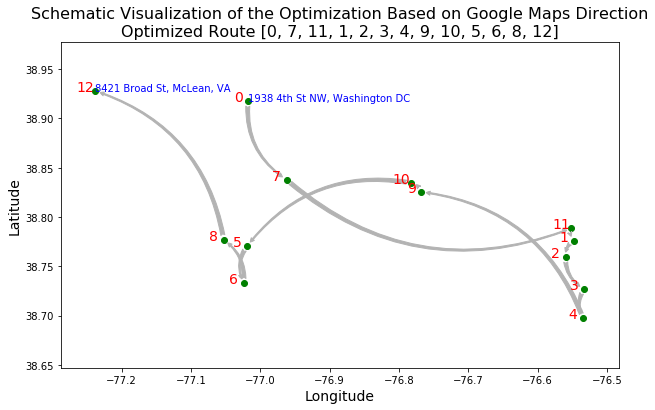

In [81]:
# plotting the optimized route along with clusters to see if the route is 
# aligned with the nieghborhood clusters

plt.figure(figsize=(10,6))
plt.scatter(props['long'], props['lat'], c='green')

# Setting plot limits as a function of property addresses
plt.xlim(min(props['long'])-0.05,max(props['long'])+0.05)
plt.ylim(min(props['lat'])-0.05,max(props['lat'])+0.05)

# Adding the title for the plot
plt.title(f'Schematic Visualization of the Optimization Based on Google Maps Direction\nOptimized Route {opt_route}',
         size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)

# Adding arrows between the points
for i in range(len(opt_route)-1):
    plt.annotate("",
                xy=(props['long'][opt_route[i+1]],props['lat'][opt_route[i+1]]), 
                 xycoords='data',
                xytext=(props['long'][opt_route[i]], props['lat'][opt_route[i]]), 
                 textcoords='data',
                arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                                color="0.7",
                                shrinkA=5, shrinkB=5,
                                patchA=None,
                                patchB=None,
                                connectionstyle="arc3,rad=0.3",
                                ),
                )

# Adding labels to points
for index in props.index:
    plt.annotate(f'{index}', # this is the text
                 (props.iloc[index,3],props.iloc[index,2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,0), # distance from text to points (x,y)
                 ha='center',  # horizontal alignment can be left, right or center
                size=14,
                c='r') 
    
# Adding the origin address to the plot
plt.annotate(props['address'][opt_route[0]],
                   xy=(props['long'][opt_route[0]], props['lat'][opt_route[0]]),
            c='blue',
            size=10)

# Adding the final destination address to the plot
plt.annotate(props['address'][opt_route[-1]],
                   xy=(props['long'][opt_route[-1]], props['lat'][opt_route[-1]]),
            c='blue',
            size=10)

plt.show();

In [19]:
# Creating a map, with the center as the mean of lat and long of all properties
map_center = (props['lat'].mean(), props['long'].mean())

# Defining the figure, to add layers
fig = gm.figure(center=map_center, zoom_level=10)

# Defining the way_points (or intermediate stops) based on the optimzied route 
# from the optimization algorithm
# This will be the input to direction layer
way_points=[]
for stop in opt_route:
    way_points.append(stop_list[stop])
    
#create the direction and markers layer
layer = gm.directions.Directions(start=stop_list[opt_route[0]],  
                                    end=stop_list[opt_route[-1]],
                                   waypoints=way_points,
                                   stroke_color='blue',
                                    stroke_opacity=0.7, 
                                    stroke_weight=4.0)

#Add the directions layer to the map
fig.add_layer(layer)

# Show the map
fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
# Looking at the optimized route
opt_route

[0, 7, 11, 1, 2, 3, 4, 9, 10, 5, 6, 8, 12]

In [21]:
# Create a dataframe based on the order of optimum route

opt_route_df = props.copy().reindex(opt_route)

opt_route_df

,id,address,lat,long
0,0,"1938 4th St NW, Washington DC",38.917248,-77.017729
7,7,"3808 Dunlap St, Temple Hills, MD",38.837668,-76.962168
11,11,"5819 Whipoorwill Dr, Deale, MD",38.788432,-76.551225
1,1,"822 Mason Ave, Deale, MD",38.776006,-76.547780
2,2,"6347 Genoa Rd, Tracys Landing, MD",38.759275,-76.559654
3,3,"719 Walnut Ave, North Beach, MD",38.726916,-76.532944
4,4,"8326 Bayside Rd, Chesapeake Beach, MD",38.697027,-76.534217
9,9,"4908 King Patrick Way, Upper Marlboro, MD",38.825238,-76.767860
10,10,"4002 Fox Gate Ln, Upper Marlboro, MD",38.834383,-76.782296
5,5,"8630 Fort Foote Rd, Fort Washington, MD",38.770520,-77.019005


In [86]:
# Defining a fuction that returns value of driving duration from add_1 to add_2
def get_distance(add_1, add_2):
    # Get distance
    distance_dict = gmaps.distance_matrix(add_1, add_2, mode ='driving')
    
    # Getting the value of duration, seconds
    distance_value = distance_dict['rows'][0]['elements'][0]['duration']['value']
    
    return distance_value

In [87]:
# Asking if the user wants to add an average site visit time.
# If a number is entered, the average time will be added to each property visit
# If no number is entered, the avergae time will be set to zero

try:
    avg_site_visit = int(input('If you want to enter an avergae time per site visit, enter in mins.\nOtherwise, just press enter:  '))
except:
    avg_site_visit = 0

If you want to enter an avergae time per site visit, enter in mins.
Otherwise, just press enter:  


In [88]:
# Create a list of addresses based on sequence of optimum route
opt_stops = []
for i in opt_route:
    opt_stops.append(props['address'][i])
    
# Instantiate a variable for calculating the total driving time
total_driving_time = 0

for i in range(len(opt_stops)-1):
    total_driving_time += get_distance(opt_stops[i], opt_stops[i+1])

# adding 30 mins per site visit
total_driving_time = total_driving_time+len(way_points)*avg_site_visit*60

# calculating hours and minutes for the drive
hr = total_driving_time // 3600
m = (total_driving_time - hr*3600) // 60 
    
print(f'Total driving time for this trip: {hr} hours and {m} minutes.')
print('='*60)
print('Important Notes:')
if avg_site_visit==0:
    print('- This duration does not take into account the time needed for damage assessment at each property.')
else:
    print(f'- This duration assumed {avg_site_visit} mins for damage assessment at each property based on user entry.')
print('- This information is based on the real-time data from Google Maps and may not take into account road closures, flooded roads, or other unusual traffic patterns due to the extreme event that have not been reported to Google Maps. The user is advised to check the new traffic patters.')



Total driving time for this trip: 3 hours and 24 minutes.
Important Notes:
- This duration does not take into account the time needed for damage assessment at each property.
- This information is based on the real-time data from Google Maps and may not take into account road closures, flooded roads, or other unusual traffic patterns due to the extreme event that have not been reported to Google Maps. The user is advised to check the new traffic patters.
